In [119]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [120]:
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Get data

In [121]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

X = train_data.copy()
X.drop(['id', 'target'], axis=1, inplace=True)

y = train_data['target']

no_id_test_data = test_data.drop('id', axis=1)

display(X.head())
display(y.head())

,gravity,ph,osmo,cond,urea,calc
0,1.013,6.19,443,14.8,124,1.45
1,1.025,5.40,703,23.6,394,4.18
2,1.009,6.13,371,24.5,159,9.04
3,1.021,4.91,442,20.8,398,6.63
4,1.021,5.53,874,17.8,385,2.21


0    0
1    0
2    0
3    1
4    1
Name: target, dtype: int64

# Missing Data

In [122]:
cols_with_missing = [col for col in X.columns if X[col].isnull().any()]

print(f'There are {len(cols_with_missing)} columns with missing values')

for i in cols_with_missing:
    print(i)

There are 0 columns with missing values


# EDA

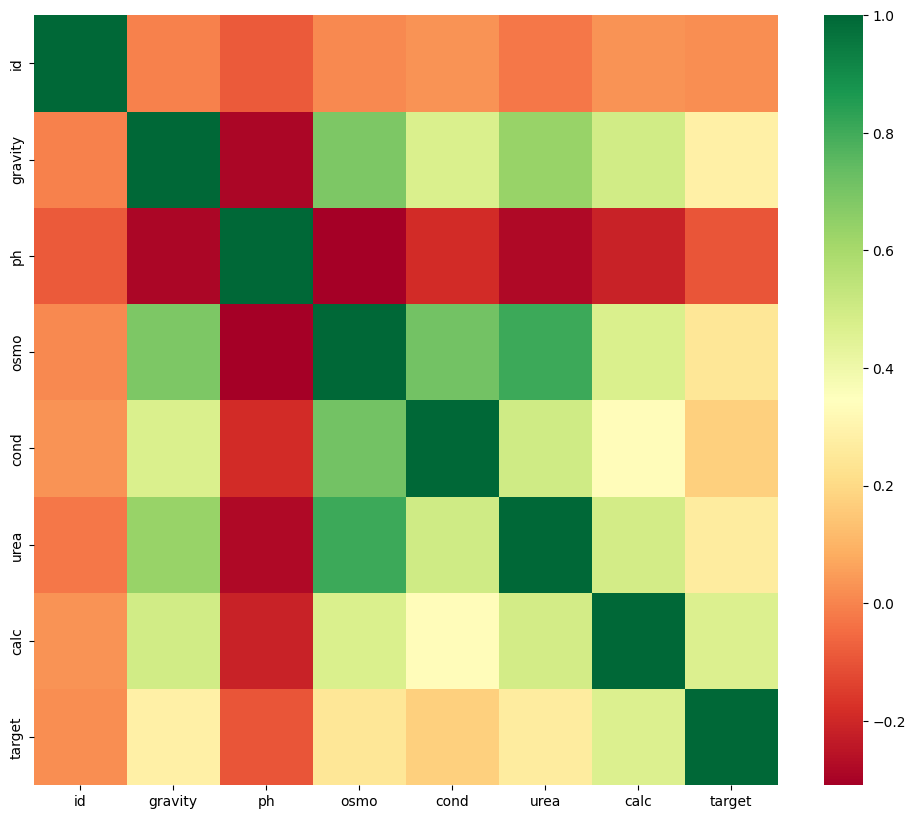

In [123]:
plt.figure(figsize=(12, 10), dpi=100)
sns.heatmap(train_data.corr(), cmap='RdYlGn')
plt.show()

# Feature Engineering

In [124]:
display(X.columns)

X.drop('ph', axis=1, inplace=True)
no_id_test_data.drop(['ph'], axis=1, inplace=True)

display(X.columns)

print(X.count());

Index(['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc'], dtype='object')

Index(['gravity', 'osmo', 'cond', 'urea', 'calc'], dtype='object')

gravity    414
osmo       414
cond       414
urea       414
calc       414
dtype: int64


# Remove Outliers

In [125]:
# Credit: KLYUSHNIK-ALEXSANDR

def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    
    
    for j in range(0, data[i].count()):
        if(data[i][j]>upper_tail or data[i][j]<lower_tail):
            data[i][j]=np.nan
    
outlier_list = ['gravity', 'osmo', 'cond', 'urea', 'calc']
for  i in outlier_list:
    outlier_removal(X ,i)

C:\Users\andar\AppData\Local\Temp\ipykernel_7160\815668155.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i][j]=np.nan


# Aggregate Features

In [126]:
def aggregate_features(data):
    my_imputer = SimpleImputer()
    data = pd.DataFrame(my_imputer.fit_transform(data))
    return data

# Preprocess Data

In [127]:
def preprocess_data(data):
    return aggregate_features(data)

X = preprocess_data(X)
no_id_test_data = preprocess_data(no_id_test_data)

cols_with_missing = [col for col in X.columns if X[col].isnull().any()]

print(f'There are {len(cols_with_missing)} columns with missing values')

for i in cols_with_missing:
    print(i)
    
    
print(X.count());



There are 0 columns with missing values
0    414
1    414
2    414
3    414
4    414
dtype: int64


# Split Data

In [128]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# Score

In [129]:
def get_score(n_estimators_=100, learning_rate_=0.5, max_depth_=6):
#     model = XGBRegressor(n_estimators=n_estimators_, max_depth=max_depth_, learning_rate=learning_rate_, 
#                          n_jobs=4)
#     model = XGBClassifier(n_estimators=n_estimators_, max_depth=max_depth_, learning_rate=learning_rate_, 
#                          n_jobs=4)
    weights = {'calc':2,'urea':1.2, 'osmo':1.2, 'ph':0.5}
    model = RandomForestClassifier(n_estimators=n_estimators_, max_depth=max_depth_, class_weight=weights)
#     model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_valid, y_valid)], verbose=
#              False)
#     predictions = model.predict(X_valid)
    scores = -1*cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error")
    return scores.mean()

# Parameter Tuning

In [130]:
# display(X_train)
# display(y_train)

# best_score=100000000
# best_n_estimators=100
# best_learning_rate=0.1
# best_max_depth=6

# for n_estimators in range(100, 401, 100):
#     score = get_score(n_estimators_=n_estimators)
    
#     if score<best_score:
#         best_score=score
#         best_n_estimators=n_estimators
        
# for learning_rate in [0.05, 0.01, 0.025, 0.05, 0.1]:
#     score = get_score(n_estimators_=best_n_estimators, learning_rate_=learning_rate);
    
#     if score<best_score:
#         best_score=score
#         best_learning_rate=learning_rate
        
# for max_depth in [2, 4, 6, 8, 10]:
#     score = get_score(n_estimators_=best_n_estimators, learning_rate_=learning_rate, 
#                       max_depth_=max_depth)
    
#     if score<best_score:
#         best_score=score
#         best_max_depth=max_depth
        
# print(f'best_score={best_score}, best_n_estimators={best_n_estimators}, best_learning_rate={best_learning_rate}, best_max_depth={best_max_depth}')

# GridSearchCV

In [131]:
# model = XGBRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, 
#                      learning_rate=best_learning_rate, n_jobs=4)
# model = XGBRegressor(random_state=69)
# model = XGBClassifier(random_state=69)
model = RandomForestClassifier(random_state=69)
to_search = {'n_estimators': [100, 500, 1000],
            'max_depth': [2, 6, 10], 
#             'learning_rate': [0.01, 0.05, 0.1]
            }

GS = GridSearchCV(estimator=model,
                           param_grid=to_search,
                           scoring=["r2", "neg_root_mean_squared_error"],
                           refit="r2",
                           cv=5,
                           verbose=False)

GS.fit(X, y)

best_params = GS.best_params_

display(best_params)

{'max_depth': 2, 'n_estimators': 1000}

# Submission

In [132]:
# final_model = XGBRegressor(
#     n_estimators = best_params['n_estimators'], 
#     max_depth = best_params['max_depth'], 
#     learning_rate = best_params['learning_rate'],
#     n_jobs=4)
# final_model = XGBClassifier(
#     n_estimators = best_params['n_estimators'], 
#     max_depth = best_params['max_depth'], 
#     learning_rate = best_params['learning_rate'],
#     n_jobs=4)
final_model = RandomForestClassifier(
    n_estimators = best_params['n_estimators'], 
    max_depth = best_params['max_depth'], 
#     learning_rate = best_params['learning_rate'],
    n_jobs=4)

final_model.fit(X, y)
predictions = final_model.predict(no_id_test_data)

submission = pd.DataFrame({'id': test_data.id, 'target': predictions})

display(submission.head())

submission.to_csv('submission.csv', index=False)

print('Successful')

,id,target
0,414,0
1,415,0
2,416,1
3,417,0
4,418,0


Successful
